# `friedrich` results

In [2]:
%matplotlib inline
# Import dev version of friedrich:
import sys
sys.path.insert(0, '../')

import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

results = json.load(open('results.json', 'r'))

depths = results['depths']
sigmas = results['sigmas']
t0s = results['t0s']
amplitudes = results['amplitudes']

# Remove anomalously deep transits from sample
max_depth = 0.004
inds = np.where(np.array(depths) > max_depth)[0]

n_deleted = 0
for i in range(len(depths)):
    if i in inds:
        depths.pop(i-n_deleted)
        sigmas.pop(i-n_deleted)
        t0s.pop(i-n_deleted)
        amplitudes.pop(i-n_deleted)
        n_deleted += 1

depths = np.array(depths)

Q: What's the distribution of spot amplitudes?

A: Strongly peaked at small values, with an exponentially declining talk to large amplitudes.

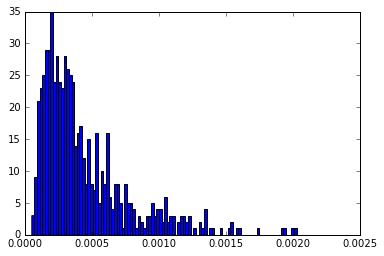

In [3]:
# High signal-to-noise spots:
high_sn_spot_inds = np.where(np.concatenate(amplitudes) > 0.0003)[0]

plt.hist(np.concatenate(amplitudes), 100);

Q: Does number of spots correlate with transit depth?

A: Not much?

R=-0.06590741186169537


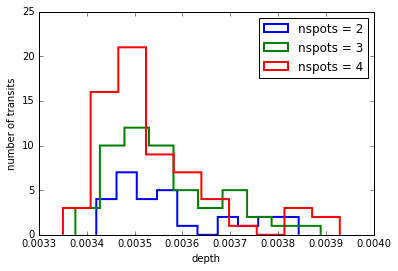

In [4]:
n_spots = np.array([len(amp) for amp in amplitudes])
pr = pearsonr(n_spots, depths)[0]

print("R={0}".format(pr))
for i in range(2, 5):
    plt.hist(depths[n_spots == i], 10, 
             label="nspots = {0}".format(i), 
             histtype='step', lw=2)
plt.legend()
plt.xlim([0.0033, 0.004])
plt.xlabel('depth')
plt.ylabel('number of transits')
plt.show()

Q: Are spots associated with certain planet orbital phases? 

A: Indubitably.

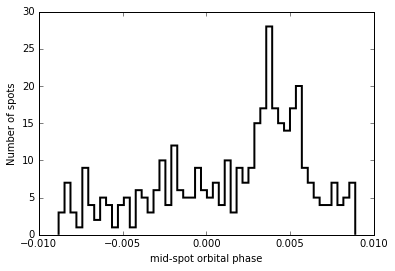

In [5]:
from friedrich.lightcurve import hat11_params_morris

hat11_params = hat11_params_morris()
period = hat11_params.per
t0 = hat11_params.t0

all_spot_orb_phases = ((np.concatenate(t0s)[high_sn_spot_inds] - t0) 
                       % period) / period
all_spot_orb_phases[all_spot_orb_phases > 0.5] -= 1

plt.hist(all_spot_orb_phases, 50, histtype='step', color='k', lw=2)
plt.xlabel('mid-spot orbital phase')
plt.ylabel('Number of spots')
plt.show()

Q: Are spots associated with stellar rotation phase? 

A: Yes!

Does this plot somehow encode the 6:1 orbit/spin commensurability?

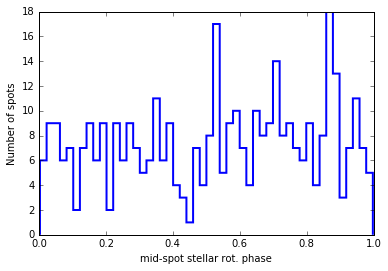

In [8]:
stellar_rotation_period = 29.9846024396
all_spot_rot_phases = ((np.concatenate(t0s)[high_sn_spot_inds] % stellar_rotation_period) 
                       / stellar_rotation_period)

plt.hist(all_spot_rot_phases, 50, histtype='step', lw=2)


plt.xlabel('mid-spot stellar rot. phase')
plt.ylabel('Number of spots')
plt.show()

Q: Are the seemingly more spotted stellar rotation phases changing in time? 

A: Maybe not.

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


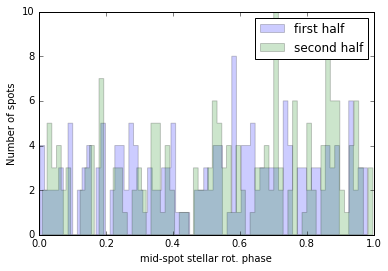

In [9]:
all_spot_rot_phases = ((np.concatenate(t0s)[high_sn_spot_inds] % stellar_rotation_period) 
                       / stellar_rotation_period)

n_bins = 70
plt.hist(all_spot_rot_phases[:len(all_spot_rot_phases)/2], n_bins, 
         histtype='stepfilled', alpha=0.2, label="first half")
plt.hist(all_spot_rot_phases[len(all_spot_rot_phases)/2:], n_bins, 
         histtype='stepfilled', alpha=0.2, label="second half")

plt.legend()
plt.xlabel('mid-spot stellar rot. phase')
plt.ylabel('Number of spots')
plt.show()